## Introduction 
This notebook aims to address the challenge of Group B, Task 1: **demand prediction for attractions and services** by 
- developing predictive models using historical data alongside external factors such as weather and events

- goal is to evaluate model performance through metrics like RMSE (Root Mean Squared Error) and R² to determine the accuracy of the predictions. 

Summary of methodology: 
- Explore the use of machine learning models, including **XGBoost** and **RandomForest**, as well as a time-series **SARIMA** model. 

- These models will be compared to identify which ones perform best in different scenarios. 
- We will focus on predicting demand at various levels, such as **hourly wait times for individual rides**, the **average wait time for each ride over the month of interest** and **overall wait times**. 

- We aim to determine the most effective model for each type of prediction and the factors influencing performance.

- Best performing model will subsequently will be employed to predict visitor count for eateries in Universal Studios Singapore.

## 1. Load data from CSVs

In [159]:
import pandas as pd
import numpy as np
import os
from faker import Faker
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
warnings.filterwarnings("ignore")

In [ ]:
weather_df = pd.read_csv('../data/weather_cleandata.csv')
waittime_df = pd.read_csv('../data/waittime_cleandata.csv')

# Rename column names for waittime_df
waittime_df['Date'] = pd.to_datetime(waittime_df['Date'], format='%d/%m/%y').dt.strftime('%Y-%m-%d')
waittime_df.rename(columns={'24h_time': 'Date/Time', 'Ride_name': 'Ride', 'Zone_name': 'Zone', 'Wait_time': 'Wait Time', 'Visitor_count': 'Visitor Count'}, inplace=True)

## 2. Generate External Factors (Date Sensitive Factors)
We will be considering the following events: 
- Public Holidays and School Holidays

- Special/ Seasonal events
    - Halloween Horror Nights
    - Minion Land Grand Opening
    - A Universal Christmas: A *Wicked* Christmas

#### Step 1: Two dictionaries on holidays and seasonal events are created.

In [161]:
# Define dictionary for Public holidays and School holidays between 1 Jan 2024- 29 Feb 2025
holidays = {
    2024: {
    "New Year’s Day": '2024-01-01',
    "Chinese New Year": '2024-02-10',
    "Chinese New Year": '2024-02-11',
    "Chinese New Year": '2024-02-12',
    "March Holidays": ['2024-03-09','2024-03-10', '2024-03-11', '2024-03-12', '2024-03-13', '2024-03-14', '2024-03-15', '2024-03-16', '2024-03-17'],
    "Good Friday": '2024-03-29',
    "Hari Raya Puasa": '2024-04-10',
    "Labour Day": '2024-05-01',
    "Vesak Day": '2024-05-22',
    "June Holidays": ['2024-05-25', '2024-05-26', '2024-05-27', '2024-05-28', '2024-05-29', '2024-05-30', '2024-05-31',
                      '2024-06-01','2024-06-02', '2024-06-03', '2024-06-04', '2024-06-05', '2024-06-06', '2024-06-07', '2024-06-08', '2024-06-09', '2024-06-10',
                      '2024-06-11', '2024-06-12', '2024-06-13', '2024-06-14', '2024-06-15', '2024-06-16', '2024-06-17', '2024-06-18', '2024-06-19', '2024-06-20',
                      '2024-06-21', '2024-06-22', '2024-06-23'],
    "Hari Raya Haji": '2024-06-17',
    "National Day": '2024-08-09',
    "September Holidays": ['2024-09-31', '2024-09-01', '2024-09-02', '2024-09-03', '2024-09-04', '2024-09-05', '2024-09-06', '2024-09-07', '2024-09-08'],
    "Deepavali": '2024-10-31',
    "December Holidays": ['2024-11-16', '2024-11-17', '2024-11-18', '2024-11-19', '2024-11-20', '2024-11-21', '2024-11-22', '2024-11-23', '2024-11-24', '2024-11-25',
                          '2024-11-26', '2024-11-27', '2024-11-28', '2024-11-29', '2024-11-30', '2024-12-01', '2024-12-02', '2024-12-03', '2024-12-04', '2024-12-05',
                          '2024-12-06', '2024-12-07', '2024-12-08', '2024-12-09', '2024-12-10', '2024-12-11', '2024-12-12', '2024-12-13', '2024-12-14', '2024-12-15',
                          '2024-12-16', '2024-12-17', '2024-12-18', '2024-12-19', '2024-12-20', '2024-12-21', '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25',
                          '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29', '2024-12-30', '2024-12-31'],
    "Christmas Day": '2024-12-25'
    },

    2025: {
    "New Year’s Day": '2025-01-01',
    "Chinese New Year": '2025-01-29',
    "Chinese New Year": '2025-01-30',
    "March Holidays": ['2025-03-15', '2025-03-16', '2025-03-17', '2025-03-18', '2025-03-19', '2025-03-20', '2025-03-21', '2025-03-22', '2025-03-23'],
    "Hari Raya Puasa": '2025-03-31',
    "Good Friday": '2025-04-18',
    "Labour Day": '2025-05-01',
    "Vesak Day": '2025-05-12',
    "June Holidays": ['2025-05-31', '2025-06-01', '2025-06-02', '2025-06-03', '2025-06-04', '2025-06-05', '2025-06-06', '2025-06-07', '2025-06-08', '2025-06-09',
                      '2025-06-10', '2025-06-11', '2025-06-12', '2025-06-13', '2025-06-14', '2025-06-15', '2025-06-16', '2025-06-17', '2025-06-18', '2025-06-19',
                      '2025-06-20', '2025-06-21', '2025-06-22', '2025-06-23', '2025-06-24', '2025-06-25', '2025-06-26', '2025-06-27', '2025-06-28', '2025-06-29'],
    "Hari Raya Haji": '2025-06-07',
    "National Day": '2025-08-09',
    "September Holidays" :['2025-09-06', '2025-09-07', '2025-09-08', '2025-09-09', '2025-09-10', '2025-09-11', '2025-09-12', '2025-09-13', '2025-09-14'],
    "Deepavali": '2025-10-20',
    "Decemeber Holidays": ['2025-11-22', '2025-11-23', '2025-11-24', '2025-11-25', '2025-11-26', '2025-11-27', '2025-11-28', '2025-11-29', '2025-11-30', '2025-12-01',
                           '2025-12-02', '2025-12-03', '2025-12-04', '2025-12-05', '2025-12-06', '2025-12-07', '2025-12-08', '2025-12-09', '2025-12-10', '2025-12-11',
                           '2025-12-12', '2025-12-13', '2025-12-14', '2025-12-15', '2025-12-16', '2025-12-17', '2025-12-18', '2025-12-19', '2025-12-20', '2025-12-21',
                           '2025-12-22', '2025-12-23', '2025-12-24', '2025-12-25', '2025-12-26', '2025-12-27', '2025-12-28', '2025-12-29', '2025-12-30', '2025-12-31'],
    "Christmas Day": '2025-12-25'
    }
}

# Define dictionary for USS special/seaonal events between 1 Jan 2024- 29 Feb 2025
seasonal_events = {
    2024: {
        "HHN": ['2024-09-27', '2024-09-28', '2024-10-03', '2024-10-04', '2024-10-05', '2024-10-10', '2024-10-11', '2024-10-12', '2024-10-17', '2024-10-18','2024-10-19',
                '2024-10-17', '2024-10-18', '2024-10-19', '2024-10-24', '2024-10-25', '2024-10-26', '2024-10-31', '2024-10-31', '2024-11-01', '2024-11-02'],
        "A Universal Christmas": ['2024-11-29', '2024-11-30', '2024-12-01', '2024-12-02', '2024-12-03', '2024-12-04', '2024-12-05', '2024-12-06', '2024-12-07', '2024-12-08',
                                  '2024-12-09', '2024-12-10', '2024-12-11', '2024-12-12', '2024-12-13', '2024-12-14', '2024-12-15', '2024-12-16', '2024-12-17', '2024-12-18',
                                 '2024-12-19', '2024-12-20', '2024-12-21', '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25', '2024-12-26', '2024-12-27', '2024-12-28',
                                 '2024-12-29', '2024-12-30', '2024-12-31']
        
    },

    2025: {
        "A Universal Christmas": '2025-01-01',
        "Minion Land Opening": '2025-02-14'
    }
}

#### Step 2: Create functions to check whether date is a holiday or seasonal event day

In [162]:
# Define function to check if a date is a public holiday
def is_public_holiday(date):
    for year in holidays:
        for holiday in holidays[year]:
            if date in holidays[year][holiday]:
                return 1
    return 0

# Define function to check if a date is a seasonal event day
def is_seasonal_event(date):
    for year in seasonal_events:
        for event in seasonal_events[year]:
            if date in seasonal_events[year][event]:
                return 1
    return 0

## 3. Generate Datafames and Synthetic Data
The 3 dataframes we will be creating are:
- attractions_df : dataframe that that contains the list of attractions

- dine_df: dataframe that lists dining options
    - calculate visitor count data every 2 hours using Survey Q14.6 

    - Question 14.6: At what time of the day do you usually visit eateries and restaurants?
    
- retail_df: dataframe that lists retail options

### 3.1 attractions_df

In [163]:
attractions_info = {
    "Ride": [
        "Accelerator",
        "Battlestar Galactica: CYLON",
        "Battlestar Galactica: HUMAN",
        "Canopy Flyer",
        "Dino-Soarin",
        "Enchanted Airways",
        "Jurassic Park Rapids Adventure",
        "Lights, Camera, Action! Hosted by Steven Spielberg",
        "Magic Potion Spin",
        "Puss In Boots’ Giant Journey",
        "Revenge of the Mummy",
        "Sesame Street Spaghetti Space Chase",
        "Shrek 4-D Adventure",
        "Transformers The Ride: The Ultimate 3D Battle",
        "Treasure Hunters"
    ],
    "Zone": [
        "Sci-Fi City", "Sci-Fi City", "Sci-Fi City", "The Lost World", "The Lost World", "Far Far Away", 
        "The Lost World", "New York", "Far Far Away", "Far Far Away", "Ancient Egypt", "New York", "Far Far Away",
        "Sci-Fi City", "Ancient Egypt"
    ],
    "Thrill": [0,1,1,1,0,1,0,0,0,0,1,0,0,0,0],  #thrill ride =1, non-thrill ride =0
    "Indoor": [1,0,0,0,0,0,0,1,1,1,1,1,1,1,0]  #indoors =1, outdoors =0
}

attractions_df = pd.DataFrame(attractions_info)
attractions_df.to_csv("attractions_df.csv")
print(attractions_df.head(10))

                                                Ride            Zone  Thrill  \
0                                        Accelerator     Sci-Fi City       0   
1                        Battlestar Galactica: CYLON     Sci-Fi City       1   
2                        Battlestar Galactica: HUMAN     Sci-Fi City       1   
3                                       Canopy Flyer  The Lost World       1   
4                                        Dino-Soarin  The Lost World       0   
5                                  Enchanted Airways    Far Far Away       1   
6                     Jurassic Park Rapids Adventure  The Lost World       0   
7  Lights, Camera, Action! Hosted by Steven Spiel...        New York       0   
8                                  Magic Potion Spin    Far Far Away       0   
9                       Puss In Boots’ Giant Journey    Far Far Away       0   

   Indoor  
0       1  
1       0  
2       0  
3       0  
4       0  
5       0  
6       0  
7       1  
8       1  

### 3.2 dine_df
Rationale:
- There are no available datasets online on wait times of eateries in Universal Studios Singapore, hence we will be generating data synthetically.

- Rather than prediciting hourly visitor count of each eatery, we will predict hourly visitor count of all eateries in a zone. 

- Individual eateries often have volatile demand, hence aggregating across a zone smooths out fluctuations and leads to more stable trends and predictions.

- Additionally, park operators are often more concerned about overall demand in a zone for staffing. Hence, prediction of eateries by zone will be conducted.

Steps to Generate Synthetic Data:
- Step 1: Generate the count of dining visitors using the number of Visitors for attractions (i.e., "Visitor Count" of waittime_df). 

- Survey Question 14.7: "At what time of the day do you usually visit souvenir shops?" The percentage distribution from this survey questions will be used to synthetically generate visitor counts, to better mimic foot traffic patterns for eateries. 

- Step 2: Factor in weights for time slot and number of restaurants in zone.

In [164]:
## Step 1: Generate count of dining visitors
# Group Watitime data by time slots
dine_df = waittime_df.copy()
dine_df["Time Slot"] = pd.cut(
    dine_df["Date/Time"],
    bins=[10, 12, 14, 16, 18, 20],
    labels=["10-12", "12-2", "2-4", "4-6", "6-8"],
    right=False
)
# Get total visitors per time slot
dine_df = dine_df.groupby(["Date", "Zone", "Time Slot"])["Visitor Count"].sum().reset_index()

# Generate percentage of visitors dining per time slot dictionary based on survey Q14.6
dining_pct = {
        "10-12" : 29.3 ,
        "12-2": 43.1,
        "2-4": 36.1,
        "4-6": 33.9,
        "6-8": 31.7,
}
# Normalize dining percentages
dining_pct_vals = {k: v / 100 for k, v in dining_pct.items()}

# Apply dining percetanges to adjust dining count
dine_df["Dining Visitor Count"] = dine_df.apply(lambda row: int(row["Visitor Count"] * dining_pct_vals[row["Time Slot"]]), axis=1)

# Scale number of dining visitors proportionate to attraction visitors
dine_df["Dining Visitor Count"] = dine_df["Dining Visitor Count"] * 0.5
dine_df.drop(columns=["Visitor Count"], inplace=True)
print(dine_df.head())

         Date           Zone Time Slot  Dining Visitor Count
0  2024-01-01  Ancient Egypt     10-12                 165.0
1  2024-01-01  Ancient Egypt      12-2                 463.0
2  2024-01-01  Ancient Egypt       2-4                 419.5
3  2024-01-01  Ancient Egypt       4-6                 229.0
4  2024-01-01  Ancient Egypt       6-8                 105.5


In [165]:
# Step 2: Adjust dining visitor count based on time slot and number of restaurants in the zone
# Create dictionary to mapo out diners and zone they belong to
dine_info = {
    "Dine": [
        "KT’s Grill", 
        "Loui’s NY Pizza Parlor", 
        "StarBot Café", 
        "Star Dots", 
        "Oasis Spice Café", 
        "Frozen Fuels", 
        "Planet Yen", 
        "Cairo Market", 
        "Discovery Food Court", 
        "Fossil Fuels", 
        "Jungle Bites", 
        "Goldilocks", 
        "Friar’s"
    ],
    "Zone":[
        "New York", "New York", "Sci-Fi City", "Sci-Fi City",
        "Ancient Egypt", "Sci-Fi City", "Sci-Fi City", "Ancient Egypt", 
        "The Lost World", "The Lost World", "The Lost World",
        "Far Far Away", "Far Far Away"
        ]
}
dine_info = pd.DataFrame(dine_info)

# Understand the number of restaurants in each zone
restaurant_count_per_zone = dine_info.groupby("Zone")["Dine"].count()
print(restaurant_count_per_zone)

def apply_timeslot_weight(row):
    if row["Time Slot"] in ["12-2", "6-8"]:
        # Increase weight for lunch and dinner time slots
        weight = 1.0
    else:
        weight = 0.8  
    adjusted_visitor_count = row["Dining Visitor Count"] * weight
    return adjusted_visitor_count

def apply_restaurant_weight(row):
    if row["Zone"] == "Sci-Fi City":
        # Increase weight for Sci-Fi City
        weight = 1.0
    if row["Zone"] == "The Lost World":
        # Increase weight for The Lost World
        weight = 0.9
    elif row["Zone"] in ["New York", "Ancient Egypt", "Far Far Away"]:
        # Increase weight for New York, Ancient Egypt, Far Far Away
        weight = 0.8
    # Apply the weight to the visitor count
    adjusted_visitor_count = row["Dining Visitor Count"] * weight
    return adjusted_visitor_count

dine_df["Adjusted Visitor Count"] = dine_df.apply(apply_timeslot_weight, axis=1)
dine_df["Adjusted Visitor Count"] = dine_df.apply(apply_restaurant_weight, axis=1).round(0).astype(int)
dine_df.drop(columns=["Dining Visitor Count"], inplace=True)
print(dine_df.head())
# dine_df.to_csv('../data/dine_cleandata.csv', index=False)

Zone
Ancient Egypt     2
Far Far Away      2
New York          2
Sci-Fi City       4
The Lost World    3
Name: Dine, dtype: int64
         Date           Zone Time Slot  Adjusted Visitor Count
0  2024-01-01  Ancient Egypt     10-12                     132
1  2024-01-01  Ancient Egypt      12-2                     370
2  2024-01-01  Ancient Egypt       2-4                     336
3  2024-01-01  Ancient Egypt       4-6                     183
4  2024-01-01  Ancient Egypt       6-8                      84


### 3.3 retail_df
- Most of the retail stores in Universal Studios Singaporeare located within the Hollywood Zone, which is primarily focused on the retail. 

- However, since we are generating synthetic data based on wait times for rides and none of the rides are in the Hollywood zone, the generated data lacks a direct connection to the actual visitor behavior in those areas. 

- As a result, even if we were to generate synthetic visitor count data for these retail zones, it would likely be random and not reflect the true patterns of demand. This makes the synthetic data unreliable and ineffective for meaningful predictions related to retail store visitor counts.

- Thus, we will focus on predicting wait time of rides and visitor count of eateries.

In [166]:
retail_info = {
    "Retail": [
        "Universal Studios Store",
        "That's a Wrap",
        "Hello Kitty Studio Store",
        "The Brown Derby",
        "Big Bird's Emporium",
        "Fairy Godmother's Potion Shop",
        "Jurassic Outfitters",
        "The Dino-Store",
        "Transformers Supply Vault" 
    ],
    "Zone": ["Hollywood", "Hollywood", "Hollywood", "Hollywood", "New York", 
            "Far Far Away", "The Lost World", "The Lost World","Sci-Fi City"
    ]
            }

retail_df = pd.DataFrame(retail_info)
print(retail_df.head())

                     Retail       Zone
0   Universal Studios Store  Hollywood
1             That's a Wrap  Hollywood
2  Hello Kitty Studio Store  Hollywood
3           The Brown Derby  Hollywood
4       Big Bird's Emporium   New York


## 4. Feature Engineering
 
Rationale: 
- Dataset for 'waittime_df' and 'dine_df' are updated by merging it with the weather dataframe to incorporate **mean temperature and daily rainfall** as additional predictors. 
- This integration allows the model to capture the potential impact of weather conditions on visitor trends and wait times.

- Additionally, we derived key features such as **day of the week, public holiday indicators, and seasonal event markers**, which could influence demand fluctuations due to calendar effects. By incorporating these features, we aim to enhance the model’s predictive accuracy and better understand the features' importance.

In [167]:
# Add features as columns to waittime_df
# for day of week, 0 = Monday,..,, 6 = Sunday
weather_df["Date"] = pd.to_datetime(weather_df["Date"])
features = ["is_holday", "is_seasonal_event", "day_of_week", "Daily Rainfall Total (mm)", "Mean Temperature (°C)"]

# Ensure 'Date' is string type first
waittime_df["is_holiday"] = waittime_df["Date"].astype(str).apply(is_public_holiday)
waittime_df["is_seasonal_event"] = waittime_df["Date"].astype(str).apply(is_seasonal_event)
waittime_df["day_of_week"] = pd.to_datetime(waittime_df["Date"]).dt.dayofweek

# Merge waititme_df with weather_df on "Date"
waittime_df['Date'] = pd.to_datetime(waittime_df['Date'])
waittime_df = waittime_df.merge(weather_df[["Date", 'Daily Rainfall Total (mm)', 'Mean Temperature (°C)']], on="Date", how="left")
waittime_df.rename(columns={'Date/Time': 'Time', 'Daily Rainfall Total (mm)': 'Rainfall (mm)', 'Mean Temperature (°C)': 'Temperature (°C)'}, inplace=True)

waittime_df['Timestamp'] = waittime_df['Date'] + pd.to_timedelta(waittime_df['Time'], unit='h')
waittime_df.to_csv("waittime_df.csv")

# Add features as columns to dine_df
# Ensure 'Date' is string type first
dine_df["is_holiday"] = dine_df["Date"].astype(str).apply(is_public_holiday)
dine_df["is_seasonal_event"] = dine_df["Date"].astype(str).apply(is_seasonal_event)
dine_df["day_of_week"] = pd.to_datetime(dine_df["Date"]).dt.dayofweek

# Merge waititme_df with weather_df on "Date"
dine_df["Date"] = pd.to_datetime(dine_df["Date"])
dine_df = dine_df.merge(weather_df[["Date", 'Daily Rainfall Total (mm)', 'Mean Temperature (°C)']], on="Date", how="left")
dine_df.rename(columns={'Date/Time': 'Time', 'Daily Rainfall Total (mm)': 'Rainfall (mm)', 'Mean Temperature (°C)': 'Temperature (°C)'}, inplace=True)
dine_df['Date'] = pd.to_datetime(dine_df['Date'])

## 5. Demand Prediction using Machine Learning Models

Rationale for choosing XGBoost and Random Forest:
-  **XGBoost** and **Random Forest** models were selected due to their strong performance in handling complex, non-linear relationships in the data. Both models are ensemble techniques that combine multiple decision trees, making them robust to overfitting and capable of capturing intricate patterns. 

- **XGBoost** was chosen for its efficiency and ability to handle large datasets, offering high predictive accuracy with optimal tuning.

- **Random Forest**, on the other hand, was selected for its simplicity and ability to perform well without extensive hyperparameter tuning, making it a reliable model for demand forecasting. 

Prediction Goals:

- We aim to predict both **hourly wait times** for each ride and the **average monthly wait time** for each ride over the next month. 

- Forecasting **hourly wait times** provides more granular insights into demand fluctuations throughout the day, helping operational teams optimize ride throughput and manage crowding effectively

- Predicting the **average monthly wait time** offers a broader view of expected demand patterns, allowing the business to better plan for resource allocation, staffing, and customer satisfaction over time. 

- These predictions are essential for **improving guest experience** and **maximizing operational efficiency**, ultimately driving higher customer satisfaction and more effective management of park resources. 

- To ensure consistency in evaluation, all models will be standardized by testing on the Accelerator ride for hourly wait time predictions. When predicting the average wait time of rides for the month, models will be assessed on their forecasted wait times for 28 February 2025. 

### 5.1 XGBoost
#### 5.1(a) XGBoost to predict hourly wait times for Accelerator attraction

Predicted hourly wait times for Accelerator on Feb 28, 2025: 
[ 5.341446   5.7599883  5.829528   6.0700607  6.103347  18.891357
 18.198431   3.3349383  3.6134107  2.8030272]
RMSE: 2.85
R² Score: 0.6946


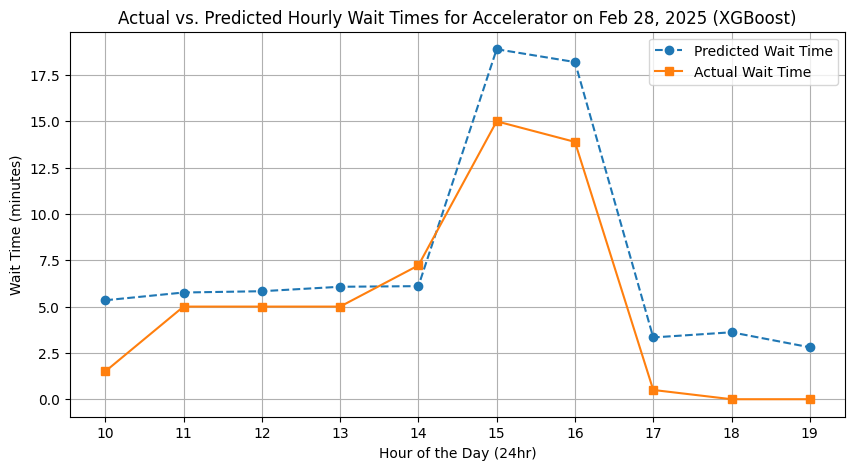

In [168]:
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime

# Filter for "Accelerator" attraction before training
waittime_df_accelerator_xg = waittime_df[waittime_df['Ride'] == "Accelerator"].copy()

# Ensure Date column is in datetime format
waittime_df_accelerator_xg['Date'] = pd.to_datetime(waittime_df_accelerator_xg['Date'], errors='coerce')

# Extract hour from Timestamp
waittime_df_accelerator_xg['Hour'] = pd.to_datetime(waittime_df_accelerator_xg['Timestamp']).dt.hour

# Identify categorical columns for encoding
categorical_columns = ["Time", "Zone", "day_of_week", "is_holiday", "is_seasonal_event"]

# OneHotEncode categorical variables
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(waittime_df_accelerator_xg[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Merge encoded categories with waittime_df
df_encoded = pd.concat([waittime_df_accelerator_xg, one_hot_df], axis=1)
df_encoded = df_encoded.drop(categorical_columns, axis=1)

# Define independent (X) and dependent (y) variables
X = df_encoded.drop(columns=['Wait Time', 'Ride', 'Timestamp']) 
y = df_encoded['Wait Time']

# Split data: Before Feb 28, 2025 is Training, Feb 28, 2025 is Testing
train_mask = X['Date'] < datetime(2025, 2, 28)
test_mask = X['Date'] == datetime(2025, 2, 28)

X_train, y_train = X[train_mask].drop(columns=['Date']), y[train_mask]
X_test = X[test_mask].drop(columns=['Date'])
y_test = y[test_mask]

# Train XGBoost Model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict wait times for Feb 28, 2025
y_pred = xgb_model.predict(X_test)

# Model performance evaluation
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Predicted hourly wait times for Accelerator on Feb 28, 2025: \n{y_pred}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Prepare data for plotting
df_predictions = X_test.copy()
df_predictions['Predicted Wait Time'] = y_pred
df_predictions['Date'] = datetime(2025, 2, 28)
df_predictions['Hour'] = waittime_df_accelerator_xg.loc[X_test.index, 'Hour'].values

df_actual = waittime_df_accelerator_xg[waittime_df_accelerator_xg['Date'] == datetime(2025, 2, 28)][['Hour', 'Wait Time']]

# Merge actual and predicted wait times
df_comparison = df_predictions.merge(df_actual, on='Hour', how='left')
df_comparison = df_comparison.rename(columns={'Wait Time': 'Actual Wait Time'})
df_comparison = df_comparison.sort_values(by=['Hour'])

# Plot predictions vs actual wait times
plt.figure(figsize=(10, 5))
plt.plot(df_comparison['Hour'], df_comparison['Predicted Wait Time'], marker='o', linestyle='--', label="Predicted Wait Time")
plt.plot(df_comparison['Hour'], df_comparison['Actual Wait Time'], marker='s', linestyle='-', label="Actual Wait Time")

plt.legend()
plt.title("Actual vs. Predicted Hourly Wait Times for Accelerator on Feb 28, 2025 (XGBoost)")
plt.xlabel("Hour of the Day (24hr)")
plt.ylabel("Wait Time (minutes)")
plt.xticks(range(10, 20, 1))  
plt.grid()
plt.show()

#### 5.1 (b) XGBoost to predict mean wait times for each ride for February 2025

Predicted wait times for Feb 2025: 
[7.252433   7.554371   7.018228   ... 0.77681077 2.9802914  2.2160342 ]
RMSE: 5.75
R² Score: 0.8974


<Figure size 1000x500 with 0 Axes>

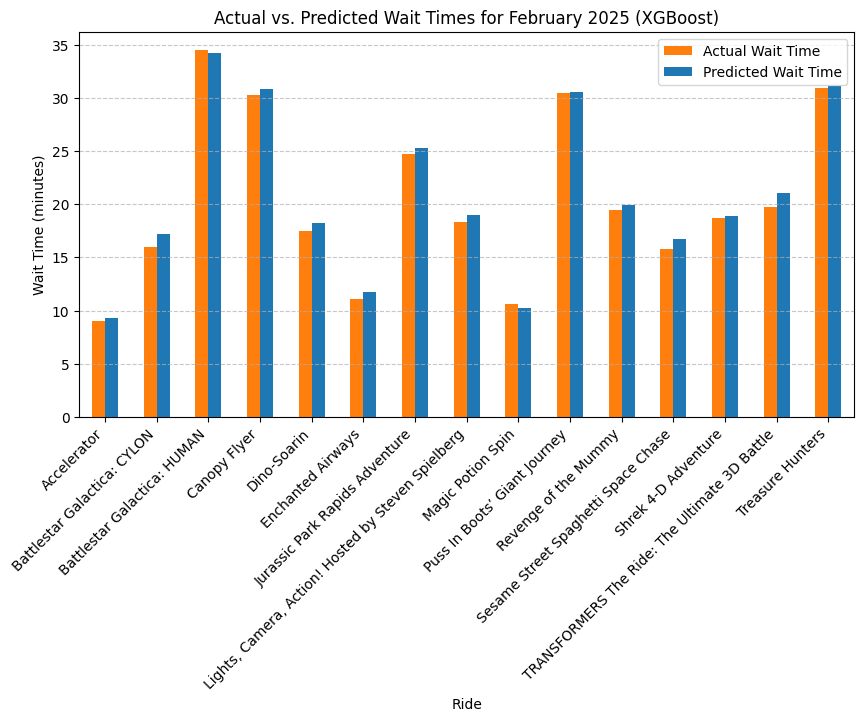

In [169]:
# Identify categorical columns for linear regression
categorical_columns = ["Ride", "Time", "Zone","day_of_week", "is_holiday", "is_seasonal_event"]
waittime_df_february_xg = waittime_df.copy()  

# Prepare OneHotEncoder for categorical columns
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(waittime_df_february_xg[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

df_encoded = pd.concat([waittime_df_february_xg, one_hot_df], axis=1)
df_encoded = df_encoded.drop(categorical_columns, axis=1)
# print(f"Encoded Waititme data : \n{df_encoded}")

# Identify independent and dependent variables
X = df_encoded.drop(columns=['Wait Time'])
y = df_encoded['Wait Time']

# Split data into training (before Feb 2025) and future prediction (Feb 2025)
X['Date'] = pd.to_datetime(X['Date'], errors='coerce')
train_mask = X['Date'] < datetime(2025, 2, 1) 
test_mask = X['Date'] >= datetime(2025, 2, 1) 

X_train, y_train = X[train_mask].drop(columns=['Date', 'Timestamp']), y[train_mask] 
X_test = X[test_mask].drop(columns=['Date', 'Timestamp'])
y_test = y[test_mask]

# Train XGBoost Model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred = xgb_model.predict(X_test)

# Model performance evaluation
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Output results
print(f"Predicted wait times for Feb 2025: \n{y_pred}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Extract actual wait times for February 2025 from df
df_feb_2025 = waittime_df[waittime_df['Date'].dt.strftime('%Y-%m') == '2025-02']

# Create a DataFrame for predictions with corresponding rides
df_predictions = X_test.copy()
df_predictions['Predicted Wait Time'] = y_pred
df_predictions['Date'] = "2025-02"  
df_predictions['Ride'] = waittime_df_february_xg.loc[X_test.index, 'Ride'].values

# Group actual and predicted data by Ride
actual_wait_times = df_feb_2025.groupby('Ride')['Wait Time'].mean()
predicted_wait_times = df_predictions.groupby('Ride')['Predicted Wait Time'].mean()

# Merge actual and predicted values for comparison
wait_time_comparison = pd.DataFrame({
    'Actual Wait Time': actual_wait_times,
    'Predicted Wait Time': predicted_wait_times
}).dropna()  

# Plot comparison of actual vs predicted wait times
plt.figure(figsize=(10, 5))
wait_time_comparison.plot(kind='bar', figsize=(10, 5), color=['tab:orange', 'tab:blue'])

plt.title("Actual vs. Predicted Wait Times for February 2025 (XGBoost)")
plt.xlabel("Ride")
plt.ylabel("Wait Time (minutes)")
plt.xticks(rotation=45, ha="right")
plt.legend(["Actual Wait Time", "Predicted Wait Time"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### 5.2 RandomForest
#### 5.2 (a) RandomForest to predict hourly wait times for Accelerator attraction

Predicted hourly wait times for Accelerator on Feb 28, 2025: 
[ 5.25478159  5.99826376  6.11078923  6.19029224  6.20648048 19.64841839
 19.36270097  3.45600222  3.94521354  2.49206336]
RMSE: 3.18
R² Score: 0.6201


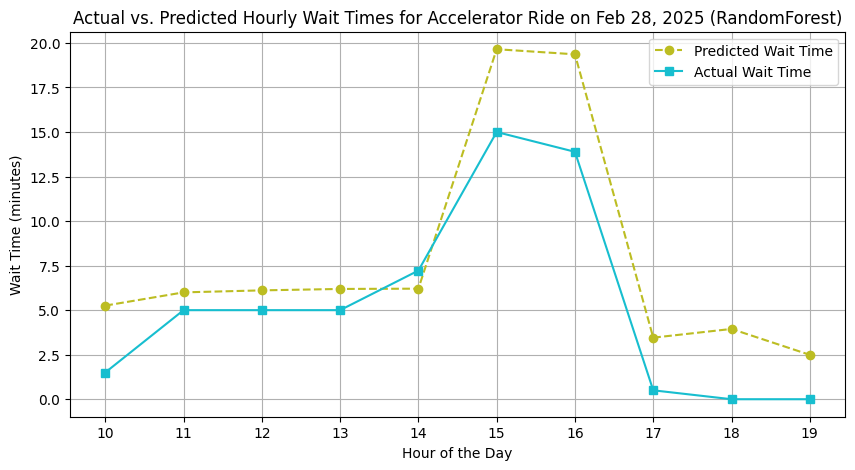

In [170]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import re
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack

# Filter for "Accelerator" attraction before training
waittime_df_accelerator_rf = waittime_df[waittime_df['Ride'] == "Accelerator"].copy()

# Ensure Date column is in datetime format
waittime_df_accelerator_rf['Date'] = pd.to_datetime(waittime_df_accelerator_rf['Date'], errors='coerce')

# Extract hour from Timestamp
waittime_df_accelerator_rf['Hour'] = pd.to_datetime(waittime_df_accelerator_rf['Timestamp']).dt.hour

# Identify categorical columns for encoding
categorical_columns = ["Time", "Zone", "day_of_week", "is_holiday", "is_seasonal_event"]

# OneHotEncode categorical variables
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(waittime_df_accelerator_rf[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Merge encoded categories with waittime_df
df_encoded = pd.concat([waittime_df_accelerator_rf, one_hot_df], axis=1)
df_encoded = df_encoded.drop(categorical_columns, axis=1)

# Define independent (X) and dependent (y) variables
X = df_encoded.drop(columns=['Wait Time', 'Ride', 'Timestamp']) 
y = df_encoded['Wait Time']

# Split data: Before Feb 28, 2025 is Training, Feb 28, 2025 is Testing
train_mask = X['Date'] < datetime(2025, 2, 28)
test_mask = X['Date'] == datetime(2025, 2, 28)

X_train, y_train = X[train_mask].drop(columns=['Date']), y[train_mask]
X_test = X[test_mask].drop(columns=['Date'])
y_test = y[test_mask]

# Train RandomForest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predict wait times for Feb 28, 2025
y_pred = rf_model.predict(X_test)

# Model performance evaluation
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Predicted hourly wait times for Accelerator on Feb 28, 2025: \n{y_pred}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Prepare data for plotting
df_predictions = X_test.copy()
df_predictions['Predicted Wait Time'] = y_pred
df_predictions['Date'] = datetime(2025, 2, 28)
df_predictions['Hour'] = waittime_df_accelerator_rf.loc[X_test.index, 'Hour'].values

df_actual = waittime_df_accelerator_rf[waittime_df_accelerator_rf['Date'] == datetime(2025, 2, 28)][['Hour', 'Wait Time']]

# Merge actual and predicted wait times
df_comparison = df_predictions.merge(df_actual, on='Hour', how='left')
df_comparison = df_comparison.rename(columns={'Wait Time': 'Actual Wait Time'})
df_comparison = df_comparison.sort_values(by=['Hour'])

# Plot predictions vs actual wait times
plt.figure(figsize=(10, 5))
plt.plot(df_comparison['Hour'], df_comparison['Predicted Wait Time'], marker='o', color = 'tab:olive', linestyle='--', label="Predicted Wait Time")
plt.plot(df_comparison['Hour'], df_comparison['Actual Wait Time'], marker='s', linestyle='-', color = 'tab:cyan', label="Actual Wait Time")

plt.legend()
plt.title("Actual vs. Predicted Hourly Wait Times for Accelerator Ride on Feb 28, 2025 (RandomForest)")
plt.xlabel("Hour of the Day")
plt.ylabel("Wait Time (minutes)")
plt.xticks(range(10, 20, 1))  
plt.grid()
plt.show()


#### 5.2 (b) RandomForest to predict mean wait times for each ride for February 2025

Predicted wait times for Feb 2025: 
[5.40796508 5.47619423 5.40796508 ... 1.32906417 2.08707423 2.59632428]
RMSE: 5.64
R² Score: 0.9014


<Figure size 1000x500 with 0 Axes>

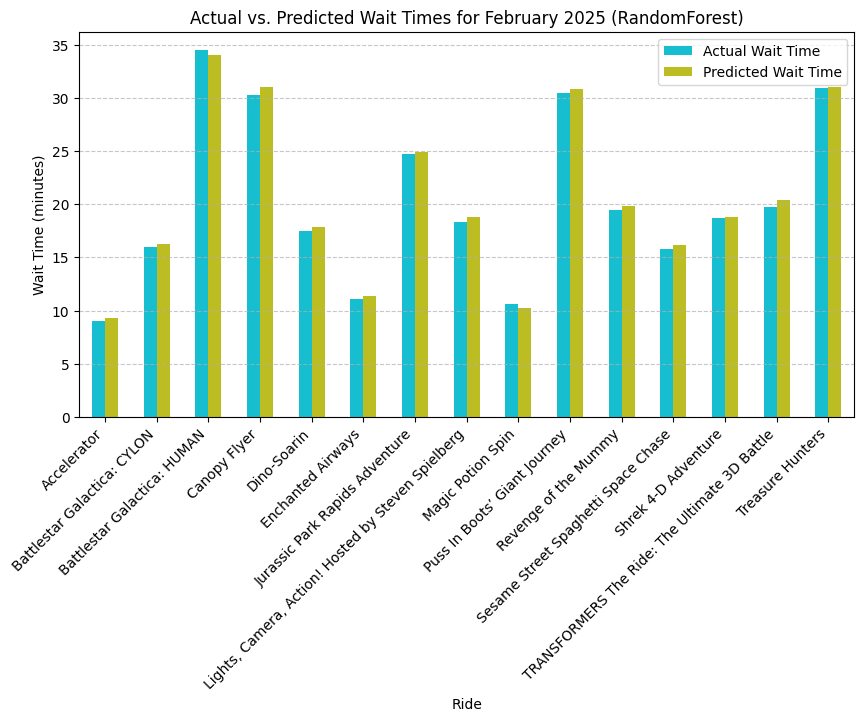

In [171]:
# Identify categorical columns for linear regression
categorical_columns = ["Ride", "Time", "Zone","day_of_week", "is_holiday", "is_seasonal_event"]
waittime_df_february_rf = waittime_df.copy() 

# Prepare OneHotEncoder for categorical columns
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(waittime_df_february_rf[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

df_encoded = pd.concat([waittime_df_february_rf, one_hot_df], axis=1)
df_encoded = df_encoded.drop(categorical_columns, axis=1)
# print(f"Encoded Waititme data : \n{df_encoded}")

# Identify independent and dependent variables
X = df_encoded.drop(columns=['Wait Time'])
y = df_encoded['Wait Time']

# Split data into training (before Feb 2025) and future prediction (Feb 2025)
train_mask = X['Date'] < datetime(2025, 2, 1) 
test_mask = X['Date'] >= datetime(2025, 2, 1) 

X_train, y_train = X[train_mask].drop(columns=['Date', 'Timestamp']), y[train_mask] 
X_test = X[test_mask].drop(columns=['Date', 'Timestamp'])
y_test = y[test_mask]

# Train RandomForest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predict wait times for Feb 28, 2025
y_pred = rf_model.predict(X_test)

# Model performance evaluation
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Output results
print(f"Predicted wait times for Feb 2025: \n{y_pred}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Extract actual wait times for February 2025 from df
df_feb_2025 = waittime_df[waittime_df['Date'].dt.strftime('%Y-%m') == '2025-02']

# Create a DataFrame for predictions with corresponding rides
df_predictions = X_test.copy()
df_predictions['Predicted Wait Time'] = y_pred
df_predictions['Date'] = "2025-02"  
df_predictions['Ride'] = waittime_df_february_rf.loc[X_test.index, 'Ride'].values

# Group actual and predicted data by Ride
actual_wait_times = df_feb_2025.groupby('Ride')['Wait Time'].mean()
predicted_wait_times = df_predictions.groupby('Ride')['Predicted Wait Time'].mean()

# Merge actual and predicted values for comparison
wait_time_comparison = pd.DataFrame({
    'Actual Wait Time': actual_wait_times,
    'Predicted Wait Time': predicted_wait_times
}).dropna()  

# Plot comparison of actual vs predicted wait times
plt.figure(figsize=(10, 5))
wait_time_comparison.plot(kind='bar', figsize=(10, 5), color=['tab:cyan', 'tab:olive'])

plt.title("Actual vs. Predicted Wait Times for February 2025 (RandomForest)")
plt.xlabel("Ride")
plt.ylabel("Wait Time (minutes)")
plt.xticks(rotation=45, ha="right")
plt.legend(["Actual Wait Time", "Predicted Wait Time"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### 5.3 Conclusion from Machine Learning Models 
Generally, for both models: 

- Monthly average wait time predictions typically yield a higher R² value compared to hourly predictions because temporal aggregation smooths out short-term noise and captures broader demand patterns. This makes the relationship between predictors and wait times more stable. 

- However, monthly averages also produce a higher RMSE because aggregation masks intraday fluctuations. Its predictions are less precise for specific hourly dynamics, resulting in larger absolute errors when compared to actual hourly observations. 

- Therefore, this reflects the trade-off between variance (R²) and minimizing prediction error (RMSE) in predictive modelling.

Performance of Models:
- The XGBoost model outperformed Random Forest for predicting hourly wait time predictions, achieving a lower RMSE and higher R² score.

- Better performance in this aspect could be attributed to XGBoost’s ability to capture complex patterns and interactions in the data, allowing it to make accurate short-term forecasts.

- On the other hand, the Random Forest model performed better in predicting average wait time for February 2025, also showing a lower RMSE and higher R² score.

- This suggest that Random Forest's ensemble approach, which creates multiple decision trees, is more suitable for longer-term predictions where data patterns can be less volatile.

## 6. Demand Prediction using Time Series Analysis

 Rationale for SARIMAX model selection:

 - Covariates, also known as exogenous variables, are external elements that can influence the time series under study. In this project's case, the covariates are the features derived earlier from feature engineering - ["Temperature (°C)","Rainfall (mm)", "day_of_week", "is_holiday", "is_seasonal_event"]. 

 - SARIMAX (Seasonal ARIMA with eXogenous variables) includes external factors that could affect seasonal time series. Hence, it is chosen as the model for our time series analysis, allowing external factors to affect the trend of observed wait time.

 Prediction Goals:
-  We will focus on predicting average daily wait times in Univeral Studios Singapore rather than hourly wait times. 

- This is because, a daily forecast offers a broader view of demand, helping to streamline operational planning, and resource allocation across the entire park. 

- Furthermore,  SARIMAX models are generally more effective when there are clear, consistent seasonal and trend patterns over a longer period (e.g., daily, weekly).

- Hourly data tends to be more volatile, and capturing short-term fluctuations effectively can be challenging with SARIMAX, which is primarily designed to handle lower-frequency time series data.



In [172]:
# Load packages
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


### 6.1 Check for Stationarity
#### Step 1: Plot out average wait times and Statistically Test for Stationarity (ADF Test)
- Plot average wait time for all USS rides between 1 January 2024 to 28 February 2025

- Plot hourly wait times for Ride, "Accelerator" between 1 January 2024 to 28 February 2025

- Aim: Plot time series data to examine characteristics of wait times


ADF Test Statistic: -3.35126883070455
P-value: 0.012736622468134841


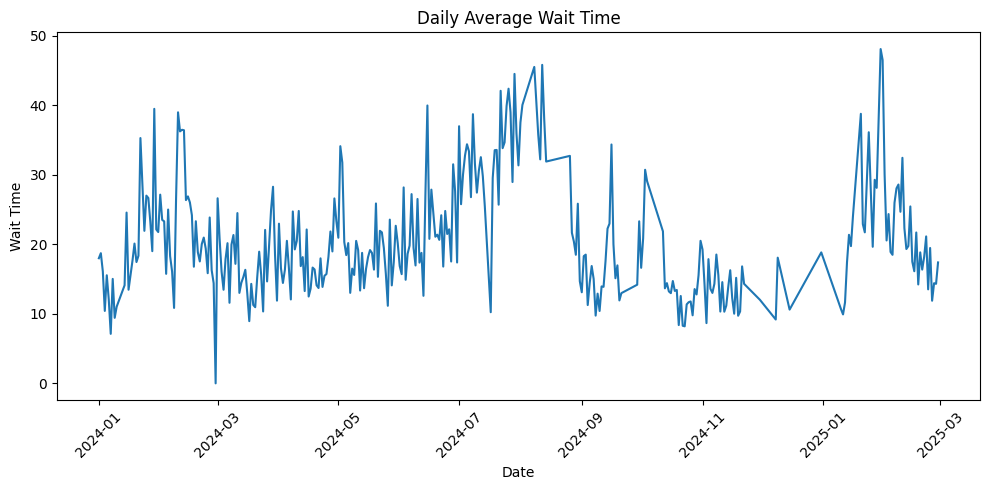

In [173]:
waittime_df_tsa = waittime_df.copy()
daily_waittime_df = waittime_df_tsa.groupby(['Date'])['Wait Time'].mean().reset_index()
daily_waittime_df.columns = ['Date', 'Average Wait Time']
daily_waittime_df['Date'] = pd.to_datetime(daily_waittime_df['Date'])

# Run ADF test on original data
adf_test = adfuller(daily_waittime_df['Average Wait Time'])
print(f"ADF Test Statistic: {adf_test[0]}")
print(f"P-value: {adf_test[1]}")

# Time Series plot
plt.figure(figsize=(10, 5))
plt.plot(daily_waittime_df['Date'], daily_waittime_df['Average Wait Time'])
plt.title('Daily Average Wait Time')
plt.xlabel('Date')
plt.ylabel('Wait Time')

plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

Conclusion from Time Series plot:

- Even though the p value is <0.05, there are recurring peaks and dips, suggesting seasonal patterns

- The spread of values change overttime, implying that variance is not constant

- Therefore, the plot for average daily wait times of rides in USS Singapore is not stationary

#### Step 2: Apply Differencing to make Time Series stationary

ADF Test (Diff): 5.645266611628006e-14


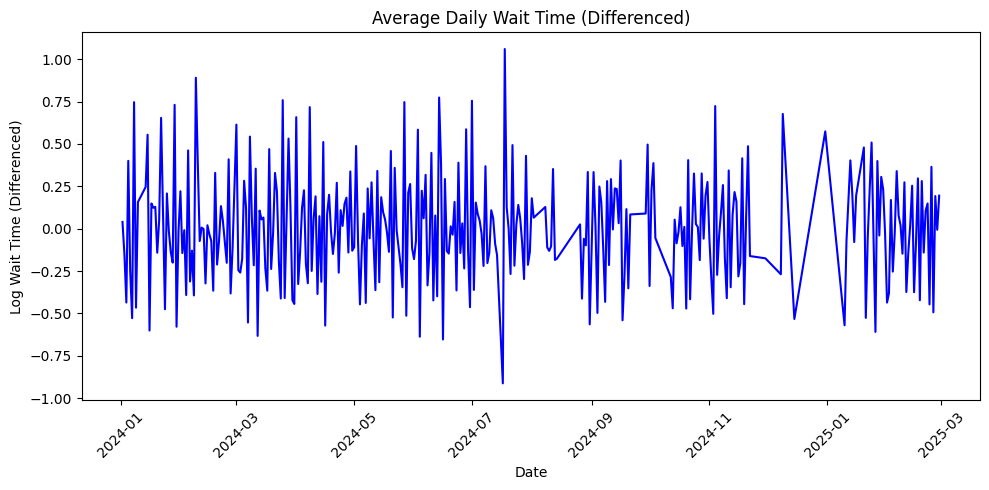

In [174]:
# Ensure 'Average Wait Time' has no zero values 
daily_waittime_df['Average Wait Time'].replace(0, np.nan, inplace=True)
daily_waittime_df.dropna(subset=['Average Wait Time'], inplace=True)

# Apply Log Transformation and First Difference
daily_waittime_df['Log Wait Time'] = np.log(daily_waittime_df['Average Wait Time']) # To stabilize variance
daily_waittime_df['Diff Wait Time'] = daily_waittime_df['Log Wait Time'].diff(periods=1) # d = 1

# Drop NaNs from Differencing
daily_waittime_df.dropna(subset=['Diff Wait Time'], inplace=True)

# Run ADF Test
if daily_waittime_df['Diff Wait Time'].isna().sum() == 0:
    adf_test_diff = adfuller(daily_waittime_df['Diff Wait Time'])
    print(f"ADF Test (Diff): {adf_test_diff[1]}")

# Plot Differenced Series
plt.figure(figsize=(10, 5))
plt.plot(daily_waittime_df['Date'], daily_waittime_df['Diff Wait Time'], color='blue')
plt.title('Average Daily Wait Time (Differenced)')
plt.xlabel('Date')
plt.ylabel('Log Wait Time (Differenced)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


- After taking the first difference in wait time, the time series is now stationary and ready for modelling

### 6.2 Identify Model Parameters
- SARIMAX model is commonly represented as  $SARIMA(p, d, q)(P, D, Q)_m$

- Identify the model's parameters ($p, d, q, P, D, Q, m$) using ACF and PACF plots
#### Step 1: Identify $p,d,q$ using normal differencing

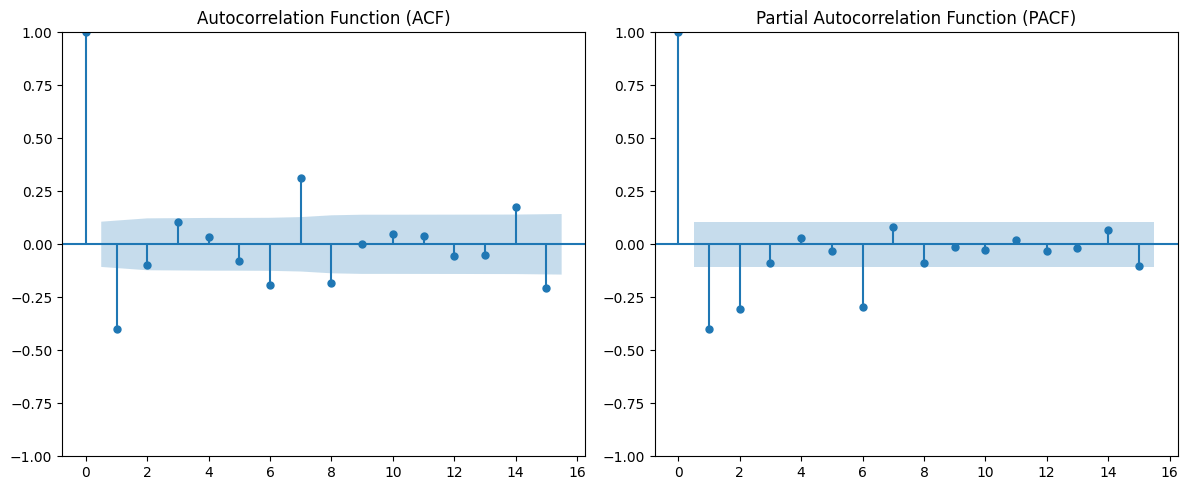

In [175]:
# Plot ACF and PACF plot of normally differenced series 
wait_time_series = daily_waittime_df["Average Wait Time"].diff().dropna()
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ACF Plot (Moving Average Order q)
sm.graphics.tsa.plot_acf(wait_time_series, lags=15, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

# PACF Plot (Autoregressive Order p)
sm.graphics.tsa.plot_pacf(wait_time_series, lags=15, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

- $p$ (AR term): Determined by the PACF plot. The PACF drops off significantly at lag 1. Hence $p = 1$

- $q$ (MA term): Determined by the ACF plot. The ACF drops off significantly at lag 1. Hence $q = 1$

- $d$ : Determined by number of differences taken. Since the plot is stationary after the first difference, $d = 1$

#### Step 2: Identify $P, D, Q, m$ using seasonal differencing

ADF Statistic: -4.488033549919769
p-value: 0.0002066653109296


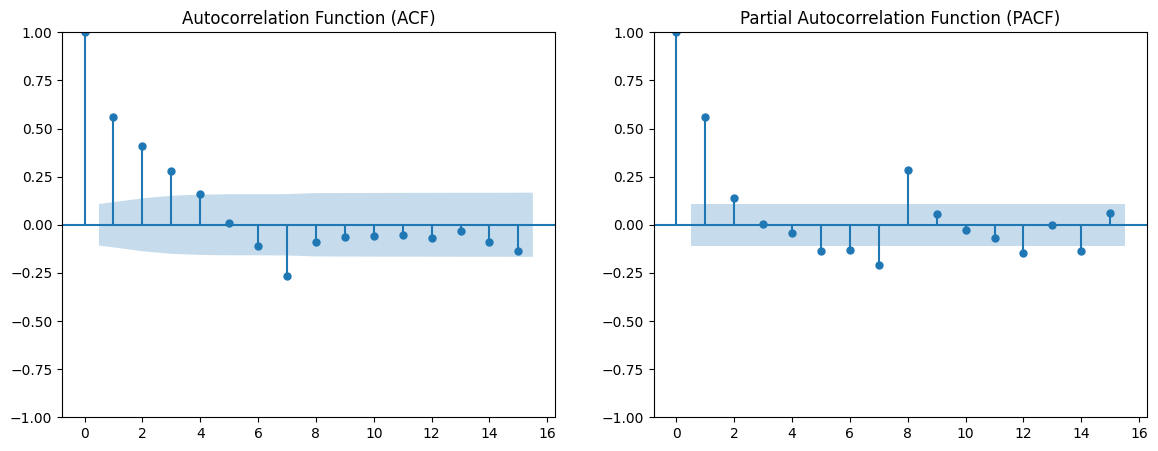

In [176]:
# Prepare Seasonal Difference
daily_waittime_df['Seasonal Diff'] = daily_waittime_df['Log Wait Time'].diff(7)
adf_test_seasonal_diff = adfuller(daily_waittime_df['Seasonal Diff'].dropna())
print("ADF Statistic:", adf_test_seasonal_diff[0])
print("p-value:", adf_test_seasonal_diff[1])

# Plot ACF and PACF plot of seasonally differenced series 
seasonal_wait_time_series = daily_waittime_df["Seasonal Diff"].dropna()
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF Plot (Moving Average Order q)
sm.graphics.tsa.plot_acf(seasonal_wait_time_series, lags=15, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

sm.graphics.tsa.plot_pacf(seasonal_wait_time_series, lags=15, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")
plt.show()

- $P$ (Seasonal AR term): Determined by the PACF plot. The PACF drops off significantly at lag 1. Hence $P = 1$

- $Q$ (Seasonal MA term): Determined by the ACF plot. The ACF has a noticeable spike at lag 1. Hence, $Q = 1$

- $D$ : Determined by number of seasonal differences taken. Since the plot is stationary after the first difference, $D = 1$

- $m$ (Length of repeating cycles): Assuming weakly seasonality, $m = 7$ is set  

### 6.3 Apply SARIMAX Model
- Use a training window of 90 days to predict daily average wait time

- Parameters
    - window_size: size of sliding window
    - n: to predict (n) number of days

- A forecast period of 7 days ($n = 7$) is chosen. This means predicting the average wait time for the next week.

- A 90-day window (window_size = $90$) was chosen to balance recency and stability: it provides sufficient historical data to capture weekly seasonality (e.g., weekend peaks) and gradual trends while avoiding excessive noise from older, less relevant data. 

- This forecast period is selected based on the assumption that the data exhibits weekly seasonality, meaning patterns repeat approximately every seven days.

          Date  Average Wait Time  Log Wait Time  Diff Wait Time  \
0   2024-04-06          16.658983       2.812950       -0.207921   
1   2024-04-07          12.074585       2.491103       -0.321847   
2   2024-04-08          24.735620       3.208244        0.717141   
3   2024-04-09          19.276245       2.958873       -0.249371   
4   2024-04-10          20.498058       3.020330        0.061457   
..         ...                ...            ...             ...   
218 2025-02-24          19.480483       2.969413        0.364699   
219 2025-02-25          11.890833       2.475768       -0.493645   
220 2025-02-26          14.414989       2.668269        0.192501   
221 2025-02-27          14.319796       2.661643       -0.006626   
222 2025-02-28          17.400974       2.856526        0.194883   

     Seasonal Diff  log_wait_time   Forecast  
0        -0.108068       2.812950  14.850121  
1         0.014321       2.491103  14.655159  
2         0.073674       3.208244  17.9684

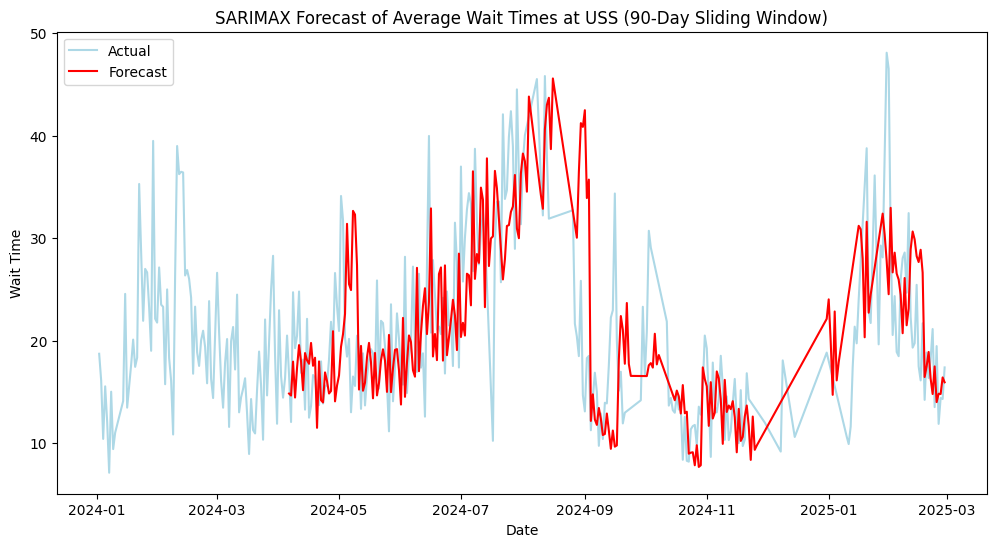

In [177]:
def predict_n_days(window_size, df, n):
    first_date = df['Date'].min()
    last_date = df['Date'].max()
    total_days = (last_date - first_date).days

    # Take log of Wait Time
    df['log_wait_time'] = np.log(df['Average Wait Time']) # Removes variance in wait times

    forecast_results = []
    forecast_dates = []
    
    for i in range(0, total_days - window_size, n):
        if i + window_size <= len(df): 
            train_window = df['log_wait_time'].iloc[i:i + window_size]
        else:
            break
        
        warnings.simplefilter("ignore", category=UserWarning)
        # Fit SARIMA model
        model = SARIMAX(train_window, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7), 
                        enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False, maxiter=500)

        # Forecast for next n days
        forecast = results.get_forecast(steps=n)
        forecast_vals = np.exp(forecast.predicted_mean)

        last_window_date = df['Date'].iloc[i + window_size - 1] 
        
        # Store each of n forecasted days
        for j in range(n):
            forecast_date = last_window_date + pd.Timedelta(days=j)
            if forecast_date <= df['Date'].max():
                forecast_results.append(forecast_vals.iloc[j])
                forecast_dates.append(forecast_date)
            else:
                break
    
    # Create dataframe for Forecast results
    forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': forecast_results})
    forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])

    return forecast_df

def plot_predictions(actual_df, forecast_df):
    plt.figure(figsize=(12, 6))
    plt.plot(actual_df['Date'], actual_df['Average Wait Time'], label='Actual', color='lightblue')
    plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='Forecast', color='red')
    plt.title("SARIMAX Forecast of Average Wait Times at USS (90-Day Sliding Window)")
    plt.xlabel('Date')
    plt.ylabel('Wait Time')
    plt.legend()
    plt.show()

def compute_metrics(actual_df, forecast_df):
    merged = actual_df.merge(forecast_df, on='Date', how='inner')
    merged = merged.dropna(subset=['Forecast'])
    print(merged)
    merged.to_csv('test.csv')
    mae = mean_absolute_error(merged['Average Wait Time'], merged['Forecast'])
    rmse = np.sqrt(mean_squared_error(merged['Average Wait Time'], merged['Forecast']))
    r2 = r2_score(merged['Average Wait Time'], merged['Forecast'])
    return {'MAE': mae, 'RMSE': rmse, 'R² Score': r2}

# Apply SARIMAX Model on daily_waittime_df
forecast_df = predict_n_days(90, daily_waittime_df, 7)
full_metrics = compute_metrics(daily_waittime_df, forecast_df)
print(full_metrics)
plot_predictions(daily_waittime_df, forecast_df)


### 6.4 Conclusion of SARIMAX model to predict average wait times at Universal Studios Singapore:
- The SARIMA model effectively captures the overall trend in average wait times, largely due to the rolling window approach, which continuously updates training data to adapt to evolving patterns. 

- However, it struggles with precise individual predictions (daily wait time), likely because short-term fluctuations—driven by unpredictable factors like sudden crowd surges. 

- While the window size of 90 days enhances trend fidelity, it may have overlooked finer-grained anomalies, highlighting a trade-off between robustness and granular accuracy. 

### 6.5 Add Exogenous Variables to SARIMA Model
#### Step 1: Define SARIMA Model (with exogenous variable)

In [178]:
from sklearn.preprocessing import StandardScaler
import warnings

def predict_n_days_with_exog(window_size, df, n, exog_columns):
    df = df.copy() 
    
    # Apply first difference then log transform
    df['diff_wait_time'] = df['Average Wait Time'].diff()
    df = df.dropna()  # Drop first NA created by differencing
    df['log_diff_wait_time'] = np.log(df['diff_wait_time'].abs() + 1e-6)  # Small constant to avoid log(0)
    
    # Initialize scaler
    scaler = StandardScaler()
    
    forecast_results = []
    forecast_dates = []
    
    # Create rolling windows
    for i in range(0, len(df) - window_size - n + 1, n):
        # Training data: use log of normally differenced values
        train_window = df['log_diff_wait_time'].iloc[i:i + window_size].reset_index(drop=True)
        train_exog = df[exog_columns].iloc[i:i + window_size]
        
        # Test data of next n days
        test_exog = df[exog_columns].iloc[i + window_size:i + window_size + n]
        
        # Skip if we don't have enough exogenous data
        if len(test_exog) < n:
            continue
            
        # Scale the exogenous variables
        train_exog_scaled = scaler.fit_transform(train_exog)
        test_exog_scaled = scaler.transform(test_exog)
        
        warnings.filterwarnings("ignore", category=UserWarning)
        # Fit model
        model = SARIMAX(train_window, 
                       order=(1, 1, 1),  # Reduced differencing since we manually differenced
                       seasonal_order=(1, 1, 1, 7),
                       exog=train_exog_scaled,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
        results = model.fit(disp=False, maxiter=100)
        
        # Forecast
        try:
            forecast = results.get_forecast(steps=n, exog=test_exog_scaled)
            # Reverse transformations: exp -> undo log, then cumsum -> undo differencing
            forecast_diff_vals = np.exp(forecast.predicted_mean) - 1e-6
            last_actual = df['Average Wait Time'].iloc[i + window_size - 1]
            forecast_vals = last_actual + forecast_diff_vals 
            
            # Store results
            last_window_date = df['Date'].iloc[i + window_size]
            for j in range(n):
                forecast_date = last_window_date + pd.Timedelta(days=j)
                forecast_results.append(forecast_vals.iloc[j])
                forecast_dates.append(forecast_date)
        except ValueError as e:
            print(f"Skipping window starting at {df['Date'].iloc[i]} due to: {str(e)}")
            continue
 
    # Create results dataframe
    print(results.summary())
    forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': forecast_results})
    forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])
    return forecast_df

#### Step 2: Apply SARIMAX model on Accelerator Ride

                                     SARIMAX Results                                     
Dep. Variable:                log_diff_wait_time   No. Observations:                   90
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -171.232
Date:                           Wed, 02 Apr 2025   AIC                            362.465
Time:                                   20:00:29   BIC                            385.369
Sample:                                        0   HQIC                           371.593
                                            - 90                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2889      0.886     -0.326      0.744      -2.025       1.447
x2             0.2347      0.649      0.362

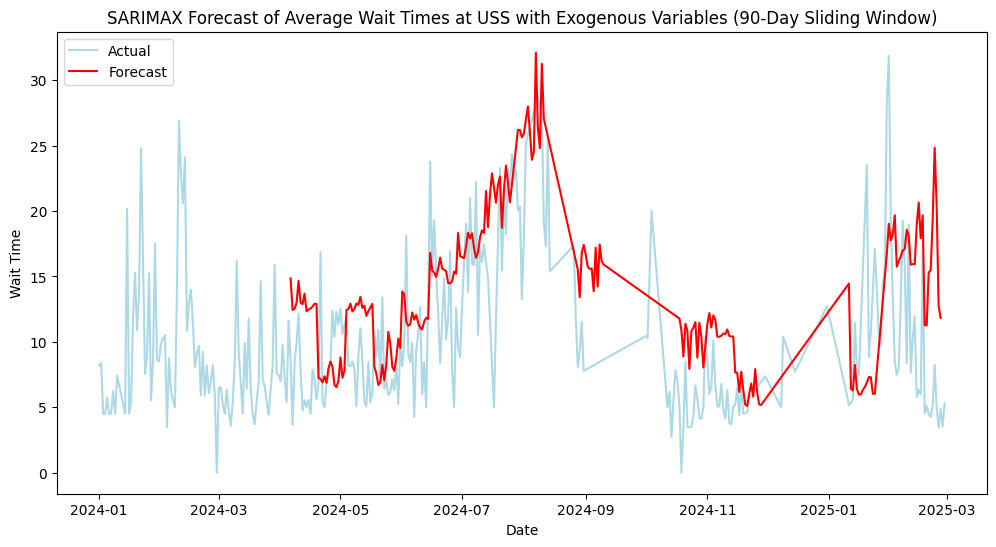

In [179]:
waittime_df_tsa = pd.read_csv('../model/waittime_df.csv')
attraction_daily_stats_df = waittime_df_tsa.groupby(['Ride', 'Date']).agg(
    {
        'Wait Time': 'mean', 
        'Temperature (°C)': 'mean', 
        'is_holiday': 'first',  
        'is_seasonal_event': 'first',  
        'Rainfall (mm)': 'mean', 
        'day_of_week': 'first',  
    }).reset_index()
attraction_daily_stats_df.rename(columns={'Wait Time': 'Average Wait Time'}, inplace=True)

# Filter for Accelerator Ride
attraction_daily_stats_df = attraction_daily_stats_df[attraction_daily_stats_df['Ride'] == "Accelerator"].copy()
attraction_daily_stats_df['Date'] = pd.to_datetime(attraction_daily_stats_df['Date'])

def plot_predictions(actual_df, forecast_df):
    plt.figure(figsize=(12, 6))
    plt.plot(actual_df['Date'], actual_df['Average Wait Time'], label='Actual', color='lightblue')
    plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='Forecast', color='red')
    plt.title("SARIMAX Forecast of Average Wait Times at USS with Exogenous Variables (90-Day Sliding Window)")
    plt.xlabel('Date')
    plt.ylabel('Wait Time')
    plt.legend()
    plt.show()

def compute_metrics(actual_df, forecast_df):
    merged = actual_df.merge(forecast_df, on='Date', how='inner')
    merged = merged.dropna(subset=['Forecast'])
    print(merged)
    mae = mean_absolute_error(merged['Average Wait Time'], merged['Forecast'])
    rmse = np.sqrt(mean_squared_error(merged['Average Wait Time'], merged['Forecast']))
    r2 = r2_score(merged['Average Wait Time'], merged['Forecast'])
    return {'MAE': mae, 'RMSE': rmse, 'R² Score': r2}

exog_columns =["Temperature (°C)","Rainfall (mm)", "day_of_week", "is_holiday", "is_seasonal_event"] # Similar to categorical columns for machine learning models
forecast_df = predict_n_days_with_exog(90, attraction_daily_stats_df, 14, exog_columns)


full_metrics = compute_metrics(attraction_daily_stats_df, forecast_df)
print(full_metrics)
plot_predictions(attraction_daily_stats_df, forecast_df)

### 6.5 Conclusion of SARIMA Model's Performance with Exogenous Variables in predicting average wait times 

- The SARIMA model with exogenous variables (weather, holidays, etc.) demonstrates mixed performance for wait time prediction. While the ADF test confirms stationarity (p=5.6e-14 after differencing), the model achieves only marginal explanatory power (R²=0.156) with substantial errors (RMSE=7.83, MAE=5.92). This suggests the current exogenous variables contribute limited predictive value, likely because:

    - Weak Correlations: The selected features (temperature, rainfall, etc.) may not strongly influence USS wait times compared to unobserved factors like real-time crowd flow or ride operations.
    - Aggregation Effects: Daily averaging of exogenous variables dilutes their hourly impact.

- Generally, the model is able to follow the trend of average wait times well, but lacks accuracy at individual day's prediction. 

### 6.6 Conclusion for Time Series models 
- The SARIMA model with exogenous variables demonstrates better predictive performance than the baseline SARIMA, as shown by its lower MAE (4.88 vs. 5.92) and RMSE (6.05 vs. 7.83). 

- While its slightly negative R² suggests limited explanatory power, this metric is less reliable for time series forecasting than error-based measures, since the mean is a poor baseline for non-stationary data. 

- The improvement in MAE and RMSE confirms that exogenous variables (weather, holidays, etc.) contribute meaningful information, though their impact remains low. 


## 7. Demand Prediction for Eateries in USS
Rationale of choosing XGBoost as model:
- Based on the models tested, XGBoost demonstrated the best performance in predicting hourly wait times. 

- Given its strong predictive capability, we will extend its use to forecast visitor counts at eateries.

- Prediction of visitor count at eateries will be done in two-hour intervals.

### 7.1 XGBoost to predict hourly wait times for eateries in a specific zone

RMSE: 100.01
R² Score': 0.62

Predictions for February 28, 2025:
               Zone Time Slot  Predicted Visitors  Actual Visitors
8475  Ancient Egypt     10-12                 107              114
8476  Ancient Egypt      12-2                 524              465
8477  Ancient Egypt       2-4                 482              309
8478  Ancient Egypt       4-6                 205               79
8479  Ancient Egypt       6-8                  59               33


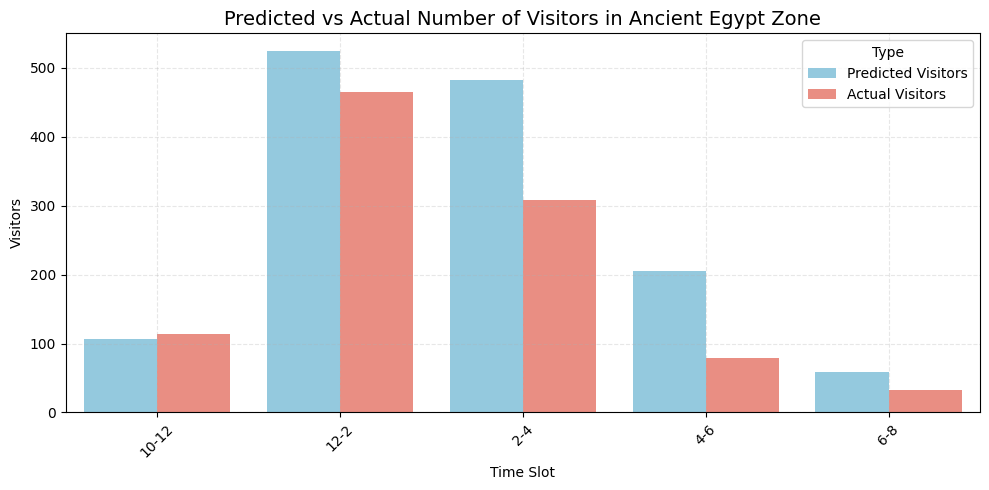

In [180]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load and prepare data for eateries in "Ancient Egypt"
df = dine_df[dine_df['Zone'] == "Ancient Egypt"].copy() 

# Convert Date to datetime and extract month as an additional feature
df['Date'] = pd.to_datetime(df['Date'])
df['month'] = df['Date'].dt.month

# Define features and target variables
features = ['Zone', 'Time Slot', 'is_holiday', 'is_seasonal_event', 
            'day_of_week', 'month', 
            'Rainfall (mm)', 'Temperature (°C)']
target = 'Adjusted Visitor Count'

# Filter data for training and testing
train_df = df[df['Date'] < '2025-02-28']
test_date = '2025-02-28'
test_df = df[df['Date'] == test_date]

# Preprocessing pipeline
categorical_features = ['Zone', 'Time Slot']
numeric_features = ['is_holiday', 'is_seasonal_event', 'day_of_week', 
                    'month', 'Rainfall (mm)', 'Temperature (°C)']

# Prepare OneHotEncoder for categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ])

# Create XGBoost model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        random_state=42
    ))
])

# Train XGBoost Model
X_train = train_df[features]
y_train = train_df[target]
model.fit(X_train, y_train)

# Predict visitor count for Feb 28, 2025
X_test = test_df[features]
predictions = model.predict(X_test)

# Create 'results' DataFrame by combining actual and predicted visitor counts
results = test_df[['Zone', 'Time Slot']].copy()
results['Predicted Visitors'] = predictions.round().astype(int)
results['Actual Visitors'] = test_df['Adjusted Visitor Count'].values

# Model performance evaluation
rmse = np.sqrt(mean_squared_error(results['Actual Visitors'], results['Predicted Visitors']))
r2 = r2_score(results['Actual Visitors'], results['Predicted Visitors'])

print(f"RMSE: {rmse:.2f}")
print(f"R² Score': {r2:.2f}")
print("\nPredictions for February 28, 2025:")
print(results[['Zone', 'Time Slot', 'Predicted Visitors', 'Actual Visitors']])

# Feature importance
feature_names = (model.named_steps['preprocessor']
                .named_transformers_['cat']
                .get_feature_names_out(categorical_features))
feature_names = np.concatenate([feature_names, numeric_features])

importances = model.named_steps['regressor'].feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

#print("\nFeature Importances:")
#print(importance_df.head(10))

# Plot predictions
plt.figure(figsize=(10, 5))
results_melted = results.melt(id_vars=['Time Slot'], 
                             value_vars=['Predicted Visitors', 'Actual Visitors'],
                             var_name='Type', value_name='Visitors')

sns.barplot(data=results_melted, x='Time Slot', y='Visitors', hue='Type',
            palette={'Predicted Visitors':'skyblue', 'Actual Visitors':'salmon'})
plt.title('Predicted vs Actual Number of Visitors in Ancient Egypt Zone', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### 7.2 Conclusion of using XGBoost to predict hourly wait times for eateries
Evaluation of XGBoost for predicting visitor count of eateries:
- The higher RMSE in this model, compared to the wait time prediction, is expected due to the nature of the target variable. Unlike wait times, which are often reported in fixed increments (multiples of 5), visitor counts vary more continuously, making them inherently more challenging to predict with the same level of precision. However, the model effectively captures the overall trend and remains relatively close to actual values, indicating a reasonable level of accuracy.

Recommendation:
- Moving forward, incorporating wait time predictions would provide additional value by enabling forecasts of customer wait durations, which would enhance the guest experience. Meanwhile, the visitor count predictions primarily serve operational needs, such as optimizing staff allocation and resource planning.

- Additionally, having granular data at the individual eatery level would improve specificity and allow for more targeted insights. However, this is currently not feasible for our model due to the use of synthetic data, which may introduce volatility and reduce reliability.

## 8. Conclusion
- Tables below summarize the performance of each model for each test case

- Refer to the Wiki Report for detailed visualizations for each attraction/service

- Generally,
    - XGBoost is best suited for hourly wait time predictions
    - Random Forest is best suited for average wait time predictions
    - SRIMAX with exogenous variables can be used to predict overall average wait times in USS

Models' Performance in predicting Hourly Wait Time for Individual Rides

| Model           | RMSE (Hourly) | R² (Hourly) |
|-----------------|---------------|-------------|
| **XGBoost**     | 2.85          | 0.6946     |
| **Random Forest** | 3.18        | 0.6201      |


Models' Performance in predicting Monthly Average Wait Time for Individual Rides for February 2025

| Model           | RMSE (Monthly) | R² (Monthly) |
|-----------------|---------------|-------------|
| **XGBoost**     | 5.75          | 0.8974      |
| **Random Forest** | 5.64        | 0.9014      |



SARIMAX's Performance in predicting average wait times in USS
| Model           | RMSE (Bi-hourly) | R² (Bi-hourly) | MAE (Bi-hourly)|
|-----------------|---------------|-------------| -------------|
| **SARIMAX**     | 7.83          | 0.156      | 5.9247      |
| **SARIMAX (with exogenous variables)**     | 6.05          | -0.001     | 4.8817      |
